In [2]:
%pip install transformers

# Cell 1: Imports & Setup
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

Note: you may need to restart the kernel to use updated packages.


d:\MCCNLP\mccenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Cell 2: Load Preprocessed Data (from Step 2)
# Re-run preprocessing if needed (copy from eda_preprocessing.ipynb)
df = pd.read_csv('data/complaints_10k.csv')
df.head()

,Unnamed: 0,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,0,2017-06-08,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,NaN,"EQUIFAX, INC.",MD,21108,NaN,NaN,Postal mail,2017-06-09,Closed with explanation,Yes,NaN,2546268
1,1,2015-05-13,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,TD BANK US HOLDING COMPANY,NJ,08759,Older American,NaN,Phone,2015-05-14,Closed with monetary relief,Yes,No,1373196
2,2,2016-03-01,Credit card,NaN,Billing disputes,NaN,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,LA,710XX,"Older American, Servicemember",NaN,Phone,2016-03-01,Closed with explanation,Yes,No,1810934
3,3,2021-03-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,"The following accounts are not mines, and is e...",NaN,"EQUIFAX, INC.",MO,NaN,NaN,Consent provided,Web,2021-03-01,Closed with explanation,Yes,NaN,4173045
4,4,2019-08-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Their investigation did not fix an error on yo...,I have submitted several disputes requesting V...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,TX,NaN,NaN,Consent provided,Web,2019-08-01,Closed with explanation,Yes,NaN,3325520


In [4]:
df_subset = df[['Consumer complaint narrative', 'Issue']].dropna()
df_subset.head()

,Consumer complaint narrative,Issue
3,"The following accounts are not mines, and is e...",Incorrect information on your report
4,I have submitted several disputes requesting V...,Problem with a credit reporting company's inve...
5,Referecnce CFPB Complaint : XXXX and XXXX This...,Attempts to collect debt not owed
10,Loancare continues to take my money but not pa...,"Loan servicing, payments, escrow account"
11,"SageStream , LLC, Consumer Office,XX/XX/XXXX X...",Incorrect information on your report


In [6]:
import nltk
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amolc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [8]:
import re
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

In [9]:
df_subset['processed_narrative'] = df_subset['Consumer complaint narrative'].apply(preprocess_text)

In [15]:
print(df_subset['processed_narrative'][10])

loancare continues take money pay mortgage xxxx xxxx keep calling wanting money month behind mortgage never missed payment find loancare sold xxxx xxxx release fund


In [16]:
X = df_subset['processed_narrative']

In [17]:
Y = df_subset['Issue']

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Train size: 2788, Test size: 697


In [21]:
# Handle Class Imbalance
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.values.reshape(-1, 1), Y_train)
X_train_resampled = X_train_resampled.flatten()
print(f"Resampled train classes: {Counter(y_train_resampled)}")

Resampled train classes: Counter({'Disclosure verification of debt': 632, 'Attempts to collect debt not owed': 632, "Charged fees or interest you didn't expect": 632, 'Incorrect information on your report': 632, 'Loan servicing, payments, escrow account': 632, 'Managing an account': 632, 'Took or threatened to take negative or legal action': 632, 'Incorrect information on credit report': 632, 'Closing your account': 632, "Problem with a credit reporting company's investigation into an existing problem": 632, 'Dealing with your lender or servicer': 632, 'Struggling to pay mortgage': 632, 'Problem with a purchase shown on your statement': 632, 'Closing on a mortgage': 632, 'Dealing with my lender or servicer': 632, 'Fraud or scam': 632, "Cont'd attempts collect debt not owed": 632, 'Problem with a lender or other company charging your account': 632, 'Taking/threatening an illegal action': 632, 'Delinquent account': 632, 'Improper use of your report': 632, 'Problem with fraud alerts or se

In [22]:
# Cell 4: Baseline Model (TF-IDF + Logistic Regression)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train_resampled)
X_test_tfidf = tfidf.transform(X_test)

In [23]:
lr_model = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train_resampled)
y_pred_lr = lr_model.predict(X_test_tfidf)
print("Baseline (Logistic Regression) Results:")
print(classification_report(Y_test, y_pred_lr))

d:\MCCNLP\mccenv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Baseline (Logistic Regression) Results:
                                                                                  precision    recall  f1-score   support

                                         Account opening, closing, or management       0.00      0.00      0.00         3
                         Advertising and marketing, including promotional offers       0.67      0.33      0.44         6
                                        Application, originator, mortgage broker       0.00      0.00      0.00         1
                     Applying for a mortgage or refinancing an existing mortgage       0.18      0.40      0.25         5
                                               Attempts to collect debt not owed       0.30      0.45      0.36        44
                                                                Balance transfer       0.00      0.00      0.00         0
                                                                Billing disputes       0.00      0.00    

d:\MCCNLP\mccenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\MCCNLP\mccenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\MCCNLP\mccenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\MCCNLP\mccenv\Lib\site-packages\sklearn\metrics\_classifi

C:\Users\amolc\AppData\Local\Temp\ipykernel_24012\2184779315.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

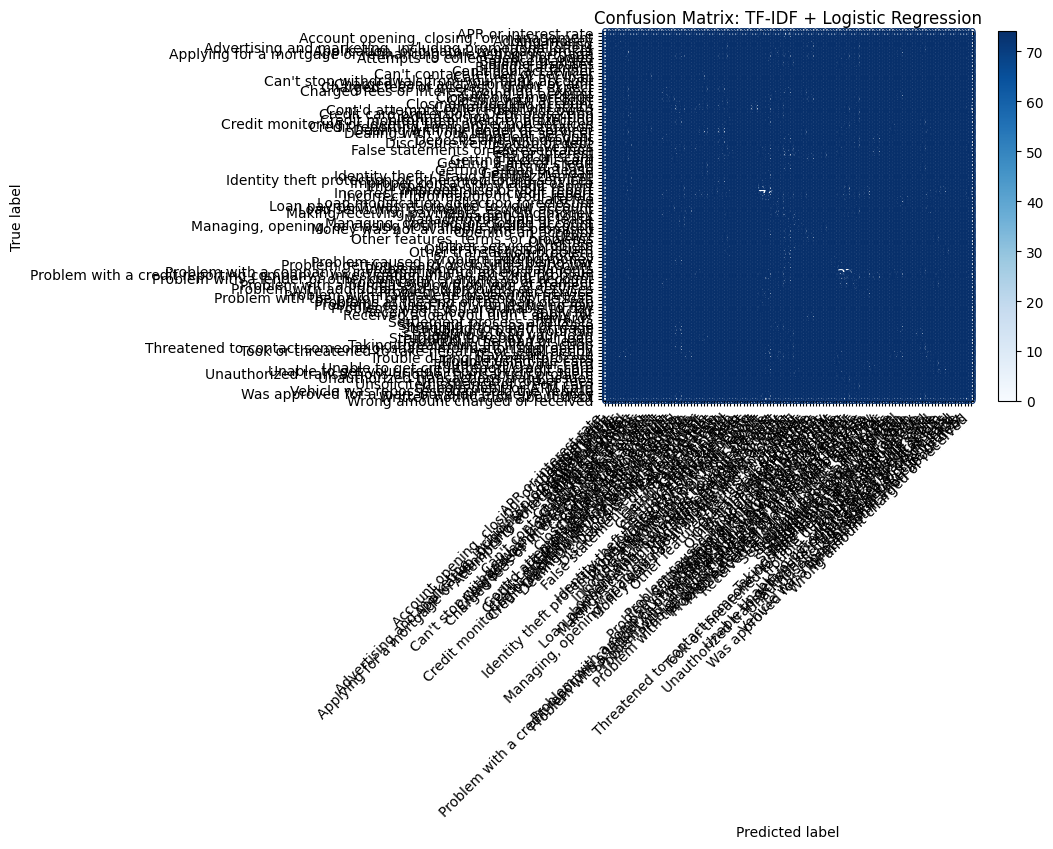

In [24]:
cm = confusion_matrix(Y_test, y_pred_lr, labels=lr_model.classes_)
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(cm, display_labels=lr_model.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix: TF-IDF + Logistic Regression')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [25]:
# BERT Model Setup
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
label_encoder = {label: idx for idx, label in enumerate(Y.unique())}
y_train_encoded = [label_encoder[label] for label in y_train_resampled]
y_test_encoded = [label_encoder[label] for label in Y_test]

d:\MCCNLP\mccenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\amolc\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [26]:
# Tokenize data
def tokenize_data(texts, max_length=128):
    return tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors='pt')

train_encodings = tokenize_data(X_train_resampled)
test_encodings = tokenize_data(X_test)

In [27]:
class ComplaintDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [28]:
train_dataset = ComplaintDataset(train_encodings, y_train_encoded)
test_dataset = ComplaintDataset(test_encodings, y_test_encoded)

In [ ]:
%pip install -U transformers
%pip install "accelerate>=0.26.0"

# Train BERT
from transformers import TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder))
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)
trainer.train()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`

In [43]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# ==============================
# 6. Trainer
# ==============================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ==============================
# 7. Train
# ==============================
trainer.train()

# ============

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.26.0`: Please run `pip install transformers[torch]` or `pip install 'accelerate>=0.26.0'`